In [4]:
# Notebook written by Shamima Rashid, Nanyang Technological University, Singapore. June 2022.
# Adapted from: machinelearningmastery.com (Jason Brownlee). 
#Version Information:
#xgboost 1.5.1
#scipy 1.8.1

In [5]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import sklearn
import seaborn as sns
from xgboost import XGBClassifier
import scipy
from pylab import savefig

#comment if 'A value is trying to be set on a slice of a copy of a dataframe' warning is needed
pd.options.mode.chained_assignment = None  # default='warn'



In [6]:
fn1 = "Sites_final_SARSCoV2.csv" #Cleaned datafile with 54484 records
                                 #B-factors not applicable as many are cryo-EM files 

In [7]:
###Only 10 relevant features are selected. Non-informative features (eg all zero columns, high correlation) 
###identified in profile report were removed
fields_1 = ['Hydropathy', 'SS', 'RSA', 'PHI', 'PSI', 'main_chain_rel', 'CA_Up', 'CA_down', 'CA_PCB_Angle', 
            'Residue_Depth', 'Target'] #10 features
fields_2 = ['Hydropathy', 'SS', 'RSA', 'PHI', 'PSI', 'main_chain_rel', 'all_polar_rel', 'CA_Up', 
             'CA_down', 'CA_PCB_Angle','CA_Up.1','CA_down.1', 'CA_Count_r12',	'Residue_Depth',
             'CA_Depth', 'Target'] #15 features
fields_4 = ['Hydropathy','SS','RSA','PHI','PSI','all_atoms_abs','all_atoms_rel','side_chain_abs',
            'side_chain_rel','main_chain_abs','main_chain_rel',	'non_polar_abs','non_polar_rel',
            'all_polar_abs', 'all_polar_rel', 'CA_Up', 'CA_down', 'CA_PCB_Angle', 'CA_Up.1', 
            'CA_down.1', 'CA_Count_r12','Residue_Depth','CA_Depth','Target'] #23 features


In [8]:
#df = pd.read_csv(fn1, usecols=fields_1)
df = pd.read_csv(fn1, usecols=fields_4)

In [9]:
#df.profile_report()
df.head(10)

,Hydropathy,SS,RSA,PHI,PSI,all_atoms_abs,all_atoms_rel,side_chain_abs,side_chain_rel,main_chain_abs,...,all_polar_rel,CA_Up,CA_down,CA_PCB_Angle,CA_Up.1,CA_down.1,CA_Count_r12,Residue_Depth,CA_Depth,Target
0,-1.3,E,0.738739,-97.6,168.8,157.01,73.8,128.42,72.4,28.60,...,91.4,6,12,0.501964,4,14,18,1.798692,2.228454,O
1,-0.7,E,0.366197,-96.1,140.1,50.43,36.2,50.09,49.3,0.34,...,42.6,5,22,0.410390,10,17,27,2.430732,2.455612,O
2,-0.9,E,0.405286,-120.6,121.4,91.00,36.5,81.50,38.6,9.50,...,15.9,13,14,0.357393,9,18,27,1.965714,2.768722,O
3,2.8,E,0.203046,-113.4,153.6,37.32,18.7,37.24,22.7,0.08,...,0.0,12,14,0.458621,16,10,26,2.195982,1.999505,O
4,-3.5,E,0.694268,-116.7,139.4,100.15,69.6,97.87,92.1,2.28,...,72.7,6,12,0.373543,5,13,18,1.761027,2.311428,O
5,3.8,E,0.036585,-107.8,120.7,4.99,2.8,4.09,2.9,0.90,...,0.1,17,13,0.385145,16,14,30,2.160453,2.630212,O
6,-3.2,E,0.548913,-107.3,164.7,99.42,54.4,90.97,61.9,8.45,...,50.5,7,16,0.551092,5,18,23,1.771420,2.177925,O
7,-0.7,E,0.140845,-162.2,124.9,20.29,14.6,19.65,19.3,0.64,...,3.3,16,9,0.476711,21,4,25,1.907131,1.999835,O
8,-1.6,E,0.816176,-71.4,133.3,117.53,86.3,99.62,83.1,17.91,...,109.2,1,17,0.547936,0,18,18,1.945653,2.385825,O
9,4.5,C,0.165680,-148.3,155.0,27.52,15.7,18.85,13.7,8.66,...,15.5,17,4,0.509686,18,3,21,1.767569,1.999490,O


In [10]:
### Drop Clade 'O' for 4-Clade classification.
X = df[df['Target'] != 'O']


In [11]:
X.head()

,Hydropathy,SS,RSA,PHI,PSI,all_atoms_abs,all_atoms_rel,side_chain_abs,side_chain_rel,main_chain_abs,...,all_polar_rel,CA_Up,CA_down,CA_PCB_Angle,CA_Up.1,CA_down.1,CA_Count_r12,Residue_Depth,CA_Depth,Target
97,-1.3,E,0.680180,-134.4,152.6,142.34,66.9,116.75,65.8,25.59,...,86.4,8,11,0.550271,7,12,19,1.824456,2.302332,V
98,-0.7,E,0.281690,-73.8,132.0,39.73,28.5,39.07,38.4,0.66,...,28.1,6,22,0.381768,8,20,28,2.488649,2.664093,V
99,-0.9,E,0.202643,-103.5,117.0,47.49,19.0,42.02,19.9,5.46,...,9.2,13,15,0.353163,10,18,28,2.527140,3.313983,V
100,2.8,E,0.071066,-108.3,153.3,14.10,7.1,14.10,8.6,0.00,...,0.0,13,18,0.492913,19,12,31,2.413790,1.999542,V
101,-3.2,C,0.375000,-122.2,154.6,67.66,37.0,64.71,44.0,2.94,...,21.7,8,18,0.437205,7,19,26,1.809812,1.999301,V


In [12]:
Clade = {'G':0, 'L':1, 'S':2,'V':3}
SS_Num = {"H":1, "E":2, "C":3}
X['Target']= X['Target'].apply(lambda x: Clade[x])
X['SS'] = X['SS'].apply(lambda x: SS_Num[x])

In [13]:
#F_names = fields_1[:-1] #Selected Feature Names
F_names = fields_4[:-1] #Selected Feature Names

In [44]:
#Set up X and Y for XGBoost Training

Y =X['Target']
X =X[F_names]
X = X.to_numpy()
Y = Y.to_numpy()
print("X - Type:", type(X), "Shape:", X.shape)
print("Y - Type:", type(Y), "Shape:", Y.shape)



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[Text(0.5, 1.0, 'True Label Distribution'), Text(0, 0.5, 'Count')]

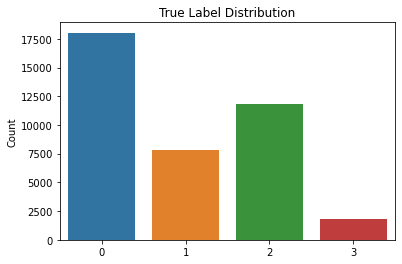

In [16]:
sns.countplot(x=Y).set(title = 'True Label Distribution', ylabel = 'Count')

In [17]:
## Prepare vector of randomly generated labels
n = 4
np.random.seed(1)
R = np.random.randint(n, size=(len(Y),))
#R=R.tolist()
print("Type:", type(R), "Shape:", R.shape)

Type: <class 'numpy.ndarray'> Shape: (39483,)


[Text(0.5, 1.0, 'Random Label Distribution'), Text(0, 0.5, 'Count')]

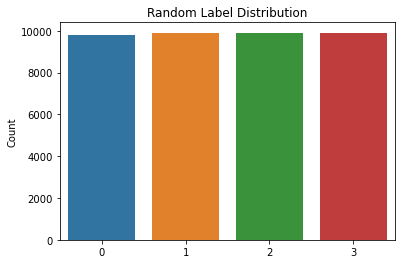

In [18]:
sns.countplot(x=R).set(title = 'Random Label Distribution', ylabel = 'Count')

In [45]:
# Test protocol.
#Prepare for actual Target and Randomly assigned SARS_COV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [46]:
#Using train_test_split()
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state = 1)
XR_train, XR_test, R_train, R_test= train_test_split(X, R, test_size=0.25, random_state = 1)

print(XR_train.shape)
print(XR_test.shape)

(29612, 23)
(9871, 23)


In [47]:
model=XGBClassifier(importance_type='gain', eval_metric='error', use_label_encoder=False)

In [48]:
model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)

In [49]:
accuracy = accuracy_score(Y_test, Y_hat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 56.31


In [50]:
Rmodel=XGBClassifier(importance_type='gain', eval_metric='error', use_label_encoder=False)
Rmodel.fit(XR_train, R_train)
R_hat = model.predict(XR_test)

In [51]:
accuracy = accuracy_score(R_test, R_hat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 24.92


In [52]:
np.random.seed(1)

In [ ]:
#### Average of n runs

n = 100
ActualLabel = []
RandomLabel = []


for i in range(n):
   
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25)
    XR_train, XR_test, R_train, R_test= train_test_split(X, R, test_size=0.25)
    model=XGBClassifier(importance_type='gain', eval_metric='error', use_label_encoder=False)
    model.fit(X_train, Y_train)
    Y_hat = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_hat)
    ActualLabel.append(accuracy)
    print('Round %0d:'% (i))
    print('True Label Accuracy: %.2f' % (accuracy*100))
    Rmodel=XGBClassifier(importance_type='gain', eval_metric='error', use_label_encoder=False)
    Rmodel.fit(XR_train, R_train)
    R_hat = model.predict(XR_test)
    accuracy = accuracy_score(R_test, R_hat)
    RandomLabel.append(accuracy)
    print('Random Label Accuracy: %.2f' % (accuracy*100))
   


In [41]:
A1 = np.asarray(ActualLabel)
R1 = np.asarray(RandomLabel)

In [42]:
A1_mean = np.mean(A1)
A1_std = np.std(A1)
print('True mean: %.2f; True s.t.d: %.3f' %(A1_mean*100, A1_std))

True mean: 56.40; True s.t.d: 0.005


In [43]:
R1_mean = np.mean(R1)
R1_std = np.std(R1)
print('Random mean: %.2f; Random s.t.d: %.3f' %(R1_mean*100, R1_std))

Random mean: 24.92; Random s.t.d: 0.004


In [ ]:
# Uncomment for feature selection
# def select_features(X_train, y_train, X_test):
#     #Code by Jason Brownlee, MachineLearningMastery.com
# 	# configure to select a subset of features
# 	fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=15)
# 	# learn relationship from training data
# 	fs.fit(X_train, y_train)
# 	# transform train input data
# 	X_train_fs = fs.transform(X_train)
# 	# transform test input data
# 	X_test_fs = fs.transform(X_test)
# 	return X_train_fs, X_test_fs, fs

In [ ]:
# X_train_fs, X_test_fs, fs = select_features(X_train, Y_train, X_test)
# XR_train_fs, XR_test_fs, Rfs = select_features(XR_train, R_train, XR_test)
# model=XGBClassifier(importance_type = 'gain')

# model.fit(X_train_fs, Y_train)
# Y_hat = model.predict(X_test_fs)


# accuracy = accuracy_score(Y_test, Y_hat)
# print('Accuracy: %.2f' % (accuracy*100))


# Rmodel=XGBClassifier(importance_type = 'gain')
# Rmodel.fit(XR_train_fs, R_train)
# R_hat = model.predict(XR_test_fs)